<div align="center">

### **EXAM #2 SIGNALS AND SYSTEMS - 2025 2S**
#### **Student:** Martín Ramírez Espinosa
##### Department of Electrical, Electronic and Computer Engineering
##### National University of Colombia - Manizales Campus

</div>

---

In [28]:
import numpy as np
import shutil
from pathlib import Path
from typing import Tuple, Optional
from yt_dlp import YoutubeDL
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from IPython.display import Audio, display
import pandas as pd
import sympy as sp
import sympy.physics.control as ctrl

---

**1.** Consider the AM demodulator shown in the following figure:

<p align="center"><img src="demodulation-system.png" alt="AM demodulation diagram" style="max-width:100%; width:85%;"></p>

Assuming $\theta_0 = 0$, analytically derive the theoretical Fourier spectrum at each stage of the scheme. Then, take 5 seconds of a YouTube song as the message signal $m(t)$ and plot in the time and frequency domains the main stages of the modulation and demodulation process, playing the associated audio in each case. For the low-pass stage, implement an ideal filter in the frequency domain using the FFT.

In [29]:
def clear_cache(
        cache_dir: Optional[str] = None  # Path to cache directory
) -> None:                               # No return value
    ''' Clears the cache directory '''
    # Determine cache path (default: ./cache)
    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "cache"
    if not cache_path.exists() or not cache_path.is_dir():
        return # Nothing to clear

    # Remove all files and directories in cache, except .gitignore
    for entry in cache_path.iterdir():
        if entry.name == ".gitignore":
            continue
        if entry.is_dir():
            shutil.rmtree(entry)
        else:
            entry.unlink()


def get_audio(
    url: str,                         # YouTube video URL
    start_s: float = 0.0,             # Start time of audio segment [s]
    duration_s: float = 5.0,          # Duration of audio segment [s]
    sample_rate_hz: int = 44100,      # Desired sample rate [Hz]
    cache_dir: Optional[str] = None,  # Path to cache directory
    clean_cache: bool = True,         # Whether to clear cache before downloading
) -> Tuple[np.ndarray, int]:          # (audio samples, sample rate)
    ''' Downloads audio from a YouTube URL and returns a segment as a numpy array '''
    # Setup cache directory
    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "cache"
    if clean_cache:
        clear_cache(cache_path)
    cache_path.mkdir(parents=True, exist_ok=True)

    # Download audio using yt-dlp
    ydl_opts = {
        "format": "bestaudio/best",                     # Best audio format
        "outtmpl": str(cache_path / "%(id)s.%(ext)s"),  # Output template
        "quiet": True,                                  # Suppress output
        "no_warnings": True,                            # Suppress warnings
    }

    # Download audio file
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)              # Extract info and download
        audio_file = cache_path / f"{info['id']}.{info['ext']}"  # Path to downloaded audio file

    # Load audio segment using pydub
    segment = AudioSegment.from_file(audio_file)                                       # Load audio file
    start_ms = max(int(start_s * 1000), 0)                                             # Start time in milliseconds
    end_ms = start_ms + int(duration_s * 1000)                                         # End time in milliseconds
    segment = segment[start_ms:end_ms].set_channels(1).set_frame_rate(sample_rate_hz)  # Mono and desired sample rate

    # Convert audio segment to numpy array
    raw = np.asarray(segment.get_array_of_samples())            # Raw audio samples
    samples = raw.astype(np.float32) / np.iinfo(raw.dtype).max  # Normalize to [-1, 1]
    return samples, sample_rate_hz

In [30]:
link = "https://www.youtube.com/watch?v=DraDpi4bM-Y"

In [31]:
msg_t, f_s = get_audio(link, start_s = 15.0)

In [32]:
def plot_domains(
        msg_t: np.ndarray,                       # Time-domain message signal
        f_s: int,                                # Sampling frequency [Hz]
        labels: Optional[dict[str, str]] = None  # Optional {'title', 't_leyend', 'f_leyend'}
) -> None:                                       # No return value
    ''' Plots the time and frequency domains of the message signal and plays the audio '''
    if labels is not None:
        expected_keys = {"title", "t_leyend", "f_leyend"}
        if not isinstance(labels, dict) or not expected_keys.issuperset(labels.keys()):
            raise ValueError("labels must be a dict with keys 'title', 't_leyend', 'f_leyend'")
    title = labels.get("title") if labels else None
    t_leyend = labels.get("t_leyend") if labels else None
    f_leyend = labels.get("f_leyend") if labels else None
    # Time domain
    N = len(msg_t)                                  # Number of samples
    T_s = 1.0 / f_s                                 # Sampling period [s]
    t = np.linspace(0.0, N*T_s, N, endpoint=False)  # Time vector
    
    # Frequency domain
    msg_f = fft(msg_t)          # Frequency-domain message signal
    f = fftfreq(N, T_s)[:N//2]  # Frequency vector

    plt.figure(figsize=(12, 6))
    if title:
        plt.suptitle(title)

    time_plot_kwargs = {"color": "blue"}
    if t_leyend:
        time_plot_kwargs["label"] = t_leyend

    # Time Domain Plot
    plt.subplot(2, 1, 1)
    plt.plot(t, msg_t, **time_plot_kwargs)
    plt.title("Time Domain")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    if t_leyend:
        plt.legend(loc="upper right")

    freq_plot_kwargs = {"color": "red"}
    if f_leyend:
        freq_plot_kwargs["label"] = f_leyend

    # Frequency Domain Plot
    plt.subplot(2, 1, 2)
    plt.plot(f, 2.0/N * np.abs(msg_f[0:N//2]), **freq_plot_kwargs)
    plt.title("Frequency Domain")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    if f_leyend:
        plt.legend(loc="upper right")

    if title:
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    else:
        plt.tight_layout()
    plt.show()
    # Play audio
    display(Audio(msg_t, rate=f_s))


In [33]:
labels = {'title': 'Original message', 't_leyend': '$m(t)$', 'f_leyend': '$M(f)$'}

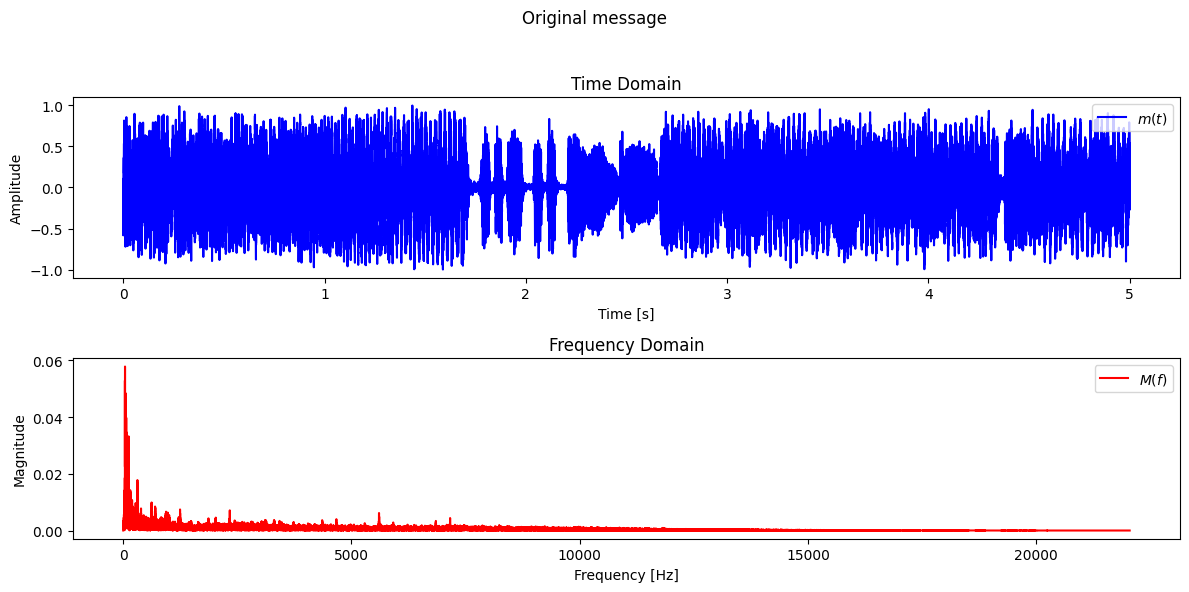

In [34]:
plot_domains(msg_t, f_s, labels)

---

In [35]:
def am_modulate(
        msg_t: np.ndarray,             # Time-domain message signal
        f_s: int,                      # Sampling frequency [Hz]
        carrier_hz: float = 10000.0,   # Carrier frequency [Hz]
        modulation_index: float = 1.0  # Modulation index (depth)
) -> np.ndarray:                       # AM modulated signal
    """Perform DSB-SC (carrier-suppressed) modulation on the message signal."""
    # Validate modulation index
    if modulation_index < 0:
        raise ValueError("modulation_index must be non-negative")
    
    # Normalize message signal
    message = np.asarray(msg_t, dtype=float)
    peak = np.max(np.abs(message))
    if peak == 0:
        return np.zeros_like(message)  # Avoid division by zero

    normalized_msg = message / peak
    t = np.arange(len(message)) / f_s
    # Carrier signal
    carrier = np.cos(2 * np.pi * carrier_hz * t)
    return modulation_index * normalized_msg * carrier

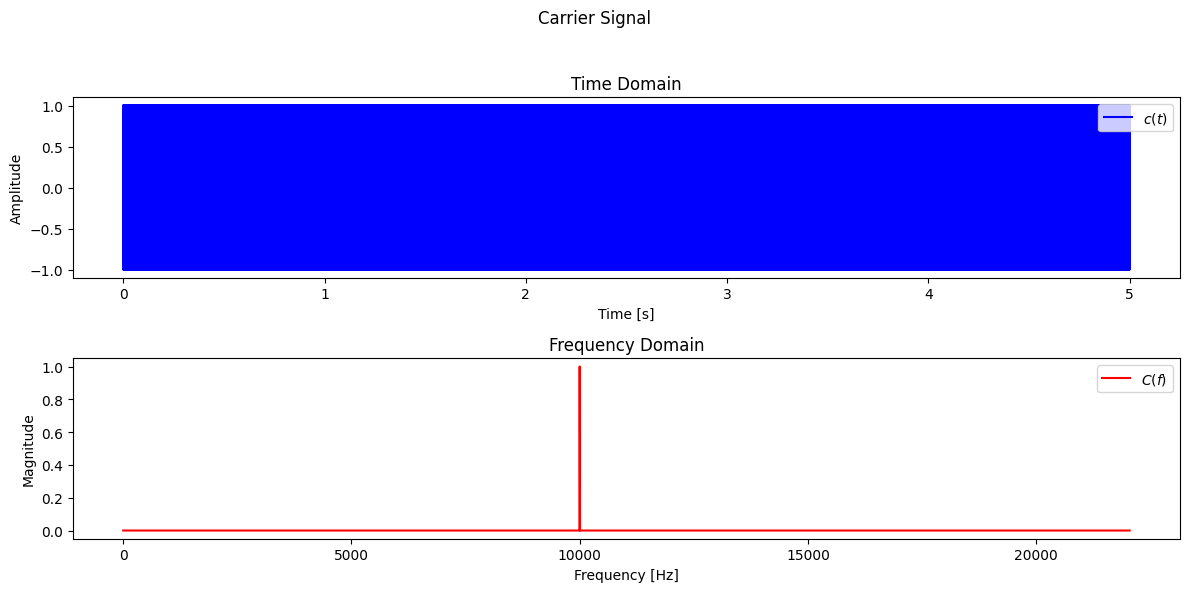

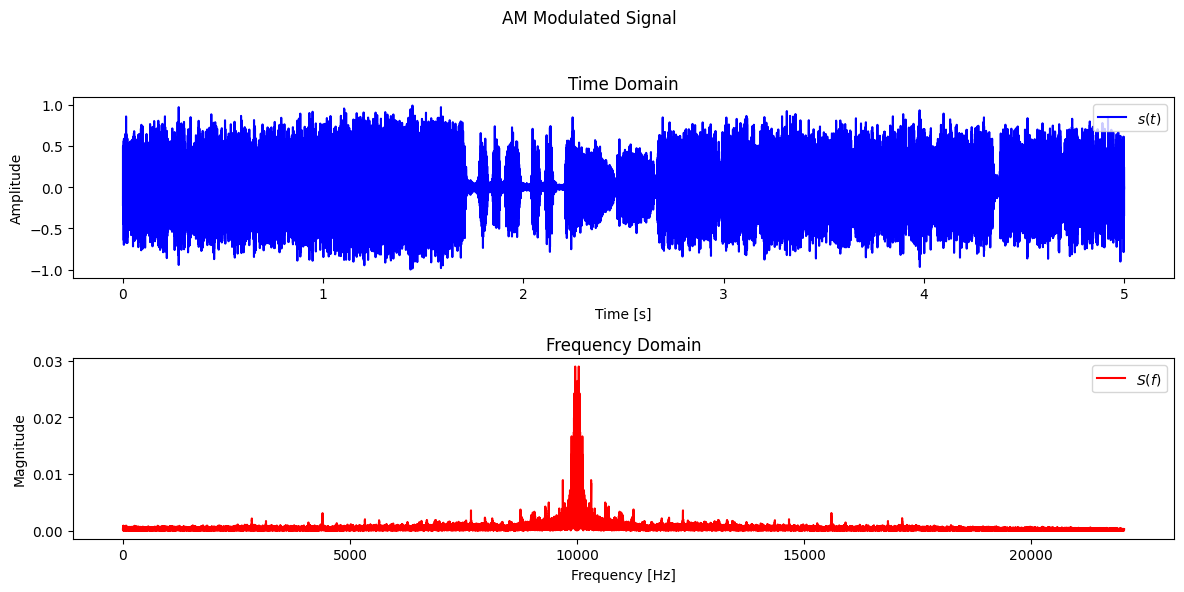

In [36]:
carrier_hz = 10000.0
labels['title'], labels['t_leyend'], labels['f_leyend'] = 'Carrier Signal', '$c(t)$', '$C(f)$'
t = np.arange(len(msg_t)) / f_s
carrier_t = np.cos(2 * np.pi * carrier_hz * t)
plot_domains(carrier_t, f_s, labels)

labels['title'], labels['t_leyend'], labels['f_leyend'] = 'AM Modulated Signal', '$s(t)$', '$S(f)$'
am_t = am_modulate(msg_t, f_s, carrier_hz=carrier_hz)
plot_domains(am_t, f_s, labels)


In [37]:
def ideal_lpf(
        signal: np.ndarray,  # Input signal
        f_s: int,            # Sampling frequency [Hz]
        cutoff_hz: float     # Cutoff frequency [Hz]
) -> np.ndarray:             # Filtered signal
    """Ideal low-pass filter via FFT magnitude masking."""
    freqs = np.fft.fftfreq(len(signal), d=1.0 / f_s)
    spectrum = np.fft.fft(signal)
    # Create ideal low-pass filter mask
    mask = np.abs(freqs) <= cutoff_hz
    return np.fft.ifft(spectrum * mask).real


def am_demodulate(
        am_t: np.ndarray,               # AM modulated signal
        f_s: int,                       # Sampling frequency [Hz]
        carrier_hz: float = 10000.0,    # Carrier frequency [Hz]
        cutoff_hz: float | None = None  # Cutoff frequency for LPF [Hz]
) -> np.ndarray:                        # Demodulated message signal
    """Demodulate a DSB-SC AM signal using coherent detection and ideal LPF."""
    if cutoff_hz is None:
        cutoff_hz = 0.45 * (f_s / 2.0)  # Default cutoff frequency [Hz]

    t = np.arange(len(am_t)) / f_s
    # Coherent detection (mixing with carrier)
    mixed = 2 * am_t * np.cos(2 * np.pi * carrier_hz * t)
    return ideal_lpf(mixed, f_s, cutoff_hz)

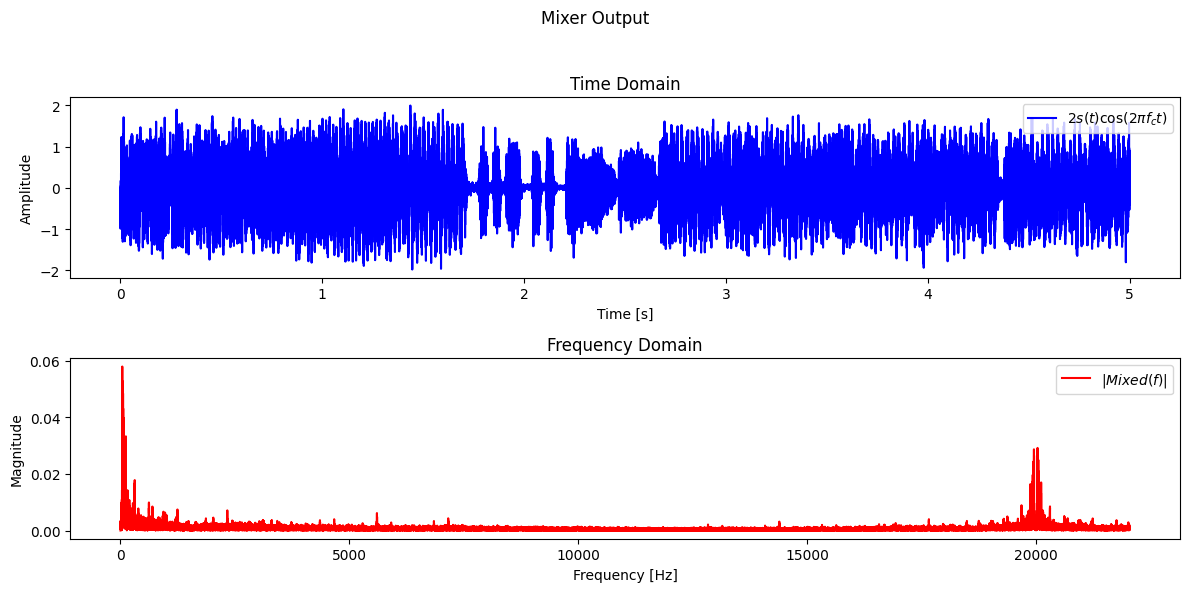

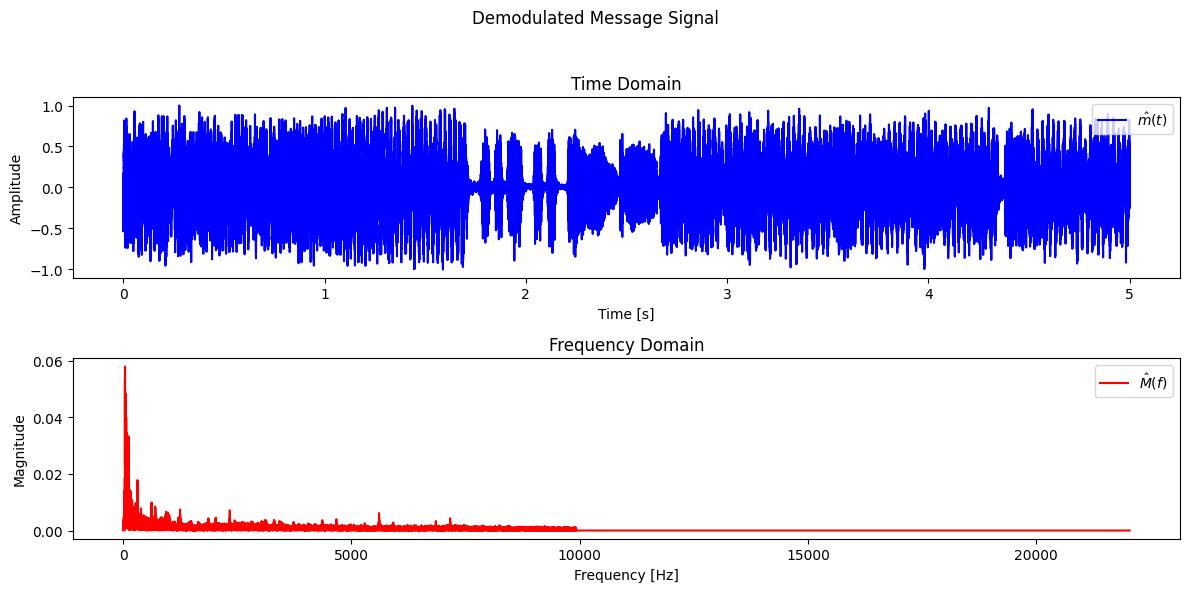

In [38]:
labels['title'], labels['t_leyend'], labels['f_leyend'] = 'Mixer Output', '$2s(t)\\cos(2\\pi f_c t)$', '$|Mixed(f)|$'
mixed_t = 2 * am_t * np.cos(2 * np.pi * carrier_hz * np.arange(len(am_t)) / f_s)
plot_domains(mixed_t, f_s, labels)

labels['title'], labels['t_leyend'], labels['f_leyend'] = 'Demodulated Message Signal', '$\\hat{m}(t)$', '$\\hat{M}(f)$'
msg_hat = am_demodulate(am_t, f_s, carrier_hz=carrier_hz)
plot_domains(msg_hat, f_s, labels)

---

**2.** Determine the transfer function that models the mass-spring-damper system shown in the following figure:

<p align="center"><img src="spring-mass-damper.png" alt="Mass-spring-damper system" style="max-width:70%; width:38%;"></p>

Next, obtain the equivalent model from the electrical circuit shown:

<p align="center"><img src="rlc-system.png" alt="Equivalent RLC circuit" style="max-width:80%; width:55%;"></p>

Propose numerical values for $m, k,$ and $c$ and their equivalents $R, L,$ and $C$ that allow you to simulate underdamped, overdamped, and critically damped regimes; for each case compute the damping ratio, the damped natural frequency, the undamped natural frequency, the peak time, the rise time, and the settling time. For each scenario, plot the pole-zero map, the Bode diagram, the impulse response, the step response, and the ramp response. Repeat the procedure for the closed-loop system.

In [39]:
# Complex frequency variable and standard second-order parameters
s = sp.symbols('s', complex=True)                       # Complex frequency [rad/s]
w_n, zeta, K = sp.symbols('w_n zeta K', real=True, positive=True)  # Natural freq, damping, gain


In [ ]:
# --- Mass-spring-damper <=> RLC helpers ---

def get_electric_params(
        mechanical_params: dict[str, float]  # Mass-spring-damper params
) -> dict[str, float]:                       # RLC params
    """Convert mass-spring-damper params to their RLC analog."""
    required = {"m", "c", "k"}
    missing = required.difference(mechanical_params)
    if missing:
        raise KeyError(f"Missing parameters: {', '.join(sorted(missing))}")

    m = float(mechanical_params["m"])
    c = float(mechanical_params["c"])
    k = float(mechanical_params["k"])
    if k == 0:
        raise ValueError("k must be non-zero to compute capacitance")
    return {"R": c, "L": m, "C": 1.0 / k}


def get_mechanical_params(
        electric_params: dict[str, float]  # RLC params
) -> dict[str, float]:                     # Mass-spring-damper params
    """Convert RLC params to their mass-spring-damper analog."""
    required = {"R", "L", "C"}
    missing = required.difference(electric_params)
    if missing:
        raise KeyError(f"Missing parameters: {', '.join(sorted(missing))}")

    R = float(electric_params["R"])
    L = float(electric_params["L"])
    C = float(electric_params["C"])
    if C == 0:
        raise ValueError("C must be non-zero to compute stiffness")
    return {"m": L, "c": R, "k": 1.0 / C}


def get_standard_params(
        params: dict[str, float]  # RLC or mass-spring-damper params
) -> dict[str, float]:            # Standard second-order params
    """Return standard second-order parameters (w_n, zeta, K)."""
    mechanical_keys = {"m", "c", "k"}
    electrical_keys = {"R", "L", "C"}

    if mechanical_keys.issubset(params):
        mechanical = {key: float(params[key]) for key in ("m", "c", "k")}
    elif electrical_keys.issubset(params):
        mechanical = get_mechanical_params(params)
    else:
        raise KeyError("params must contain either {'m', 'c', 'k'} or {'R', 'L', 'C'}")

    m = mechanical["m"]
    c = mechanical["c"]
    k = mechanical["k"]
    if m == 0 or k == 0:
        raise ValueError("m and k must be non-zero to compute standard parameters")

    wn_val = float(np.sqrt(k / m))
    zeta_val = float(c / (2 * np.sqrt(m * k)))
    K_val = float(1.0 / k)
    return {"w_n": wn_val, "zeta": zeta_val, "K": K_val}


def classify_damping(
        standard_params: dict[str, float]  # Standard second-order params
) -> str:                                  # Damping category
    """Return the damping type based on zeta."""
    required = {"w_n", "zeta", "K"}
    missing = required.difference(standard_params)
    if missing:
        raise KeyError(f"Missing parameters: {', '.join(sorted(missing))}")

    zeta_val = float(standard_params["zeta"])
    eps = 1e-6
    if abs(zeta_val - 1.0) <= eps:
        return "critically damped"
    if zeta_val < 1.0:
        return "underdamped"
    return "overdamped"


def symbolic_transfer_function(
        closed_loop: bool = False    # Whether to include unity feedback
) -> tuple[sp.Expr, list[sp.Expr]]:  # (Transfer function, symbolic poles)
    """Return the symbolic transfer function and its poles."""
    H_open = (K * w_n**2) / (s**2 + 2 * zeta * w_n * s + w_n**2)
    H = sp.simplify(H_open / (1 + H_open)) if closed_loop else sp.simplify(H_open)
    denom = sp.denom(sp.together(H))
    poles = sp.solve(sp.Eq(denom, 0), s)
    return H, poles


def instantiate_transfer_function(
        standard_params: dict[str, float],  # Standard parameters
        closed_loop: bool                   # Open/closed loop flag
) -> ctrl.TransferFunction:                 # Numerical transfer function
    """Create a control.TransferFunction from the symbolic expression."""
    H_sym, _ = symbolic_transfer_function(closed_loop=closed_loop)
    subs = {w_n: standard_params["w_n"], zeta: standard_params["zeta"], K: standard_params["K"]}
    H_eval = sp.simplify(H_sym.subs(subs))
    num_expr, den_expr = sp.fraction(sp.together(H_eval))
    return ctrl.TransferFunction(num_expr, den_expr, s)


def loop_standard_params(
        tf_obj: ctrl.TransferFunction  # Transfer function to analyze
) -> dict[str, float | str]:           # Derived params and damping label
    """Compute natural frequency, damping ratio, and gain from a second-order TF."""
    den_poly = sp.Poly(sp.expand(tf_obj.den), tf_obj.var)
    coeffs = [float(sp.N(c)) for c in den_poly.all_coeffs()]
    if len(coeffs) < 3:
        raise ValueError("Transfer function is not at least second order.")
    a0, a1, a2 = coeffs[0], coeffs[1], coeffs[2]
    wn_val = float(np.sqrt(a2 / a0))
    zeta_val = float(a1 / (2 * np.sqrt(a0 * a2)))
    wd_val = wn_val * np.sqrt(max(1 - zeta_val**2, 0.0))
    dc_gain = float(sp.N(tf_obj.num.subs(tf_obj.var, 0) / tf_obj.den.subs(tf_obj.var, 0)))
    damping = classify_damping({"w_n": wn_val, "zeta": zeta_val, "K": dc_gain if dc_gain != 0 else 1.0})
    return {"w_n": wn_val, "zeta": zeta_val, "w_d": wd_val, "K": dc_gain, "damping": damping}


def get_time_response_metrics(
        system: ctrl.TransferFunction,     # Numerical TF
        responses: dict[str, bool],        # {'impulse', 'step', 'ramp'} flags
        standard_params: dict[str, float]  # w_n, zeta, K
) -> pd.DataFrame:                         # Metrics table
    """Return key time-domain metrics for the specified response type."""
    required_params = {"w_n", "zeta", "K"}
    missing_params = required_params.difference(standard_params)
    if missing_params:
        raise KeyError(f"Missing parameters: {', '.join(sorted(missing_params))}")

    expected_responses = {"impulse", "step", "ramp"}
    if set(responses.keys()) != expected_responses:
        raise KeyError("responses must contain the keys 'impulse', 'step', and 'ramp'")

    active = [k for k, v in responses.items() if v]
    if len(active) != 1:
        raise ValueError("Exactly one response type must be set to True")

    w_n_val = float(standard_params["w_n"])
    zeta_val = float(standard_params["zeta"])
    w_d_val = w_n_val * np.sqrt(max(1 - zeta_val**2, 0.0))

    data = {"w_n": w_n_val, "zeta": zeta_val, "w_d": w_d_val}
    if active[0] == "step" and zeta_val < 1.0 and w_d_val > 0:
        phi = np.arctan(np.sqrt(max(1 - zeta_val**2, 0.0)) / max(zeta_val, 1e-12))
        T_r = float((np.pi - phi) / w_d_val)
        T_p = float(np.pi / w_d_val)
        T_s = float("inf") if zeta_val == 0 else float(4.0 / (zeta_val * w_n_val))
        data.update({"T_p": T_p, "T_r": T_r, "T_s": T_s})
    return pd.DataFrame([data])


def bode_plot_tf(
        system: ctrl.TransferFunction,  # Numerical TF
        freq_decades=(-2, 3),           # (start_exp, stop_exp) decades
        title: str | None = None        # Optional plot title
) -> None:                              # No return value
    """Plot Bode magnitude/phase using sympy.control."""
    plt.figure(figsize=(8, 6))
    ctrl.bode_plot(system, initial_exp=freq_decades[0], final_exp=freq_decades[1], grid=True, show_axes=False, show=False)
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def pole_zero_plot_tf(
        system: ctrl.TransferFunction,  # Numerical TF
        title: str | None = None        # Optional plot title
) -> None:                              # No return value
    """Plot poles and zeros for the given system."""
    zeros, poles = ctrl.pole_zero_numerical_data(system)
    zeros = np.asarray(zeros, dtype=complex)
    poles = np.asarray(poles, dtype=complex)
    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    if zeros.size:
        ax.scatter(zeros.real, zeros.imag, marker="o", facecolors="none", edgecolors="tab:orange", label="Zeros")
    if poles.size:
        ax.scatter(poles.real, poles.imag, marker="x", color="tab:blue", label="Poles")
    vals = np.concatenate([zeros.real, zeros.imag, poles.real, poles.imag]) if (zeros.size or poles.size) else np.array([1.0])
    max_range = float(np.max(np.abs(vals)))
    limit = max(1.0, max_range * 1.2)
    ax.axhline(0, color="grey", linewidth=0.8)
    ax.axvline(0, color="grey", linewidth=0.8)
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_xlabel("Re{s}")
    ax.set_ylabel("Im{s}")
    ax.set_title(title or "Pole–zero map")
    ax.grid(True, ls="--", lw=0.6)
    if zeros.size or poles.size:
        ax.legend(loc="best")
    fig.tight_layout()
    plt.show()


def time_response_plot(
        system: ctrl.TransferFunction,  # Numerical TF
        response: str,                  # 'impulse' | 'step' | 'ramp'
        horizon: float                  # Time span for simulation
) -> None:                              # No return value
    """Plot impulse/step/ramp responses using control numerical data."""
    response_key = response.lower()
    if response_key == "impulse":
        t, y = ctrl.impulse_response_numerical_data(system, upper_limit=horizon, adaptive=False, n=600)
        title = "Impulse response"
    elif response_key == "step":
        t, y = ctrl.step_response_numerical_data(system, upper_limit=horizon, adaptive=False, n=600)
        title = "Step response"
    else:
        t, y = ctrl.ramp_response_numerical_data(system, upper_limit=horizon, adaptive=False, n=600)
        title = "Ramp response"
    plt.figure(figsize=(7.5, 3.5))
    plt.plot(t, y, color="C3")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True, ls="--", lw=0.6)
    plt.tight_layout()
    plt.show()


def choose_time_window(
        wn: float,       # Natural frequency
        zeta_val: float  # Damping ratio
) -> float:              # Suggested simulation horizon [s]
    """Select a simulation window based on damping and natural frequency."""
    base = max(8.0 / max(wn, 1e-6), 0.4)
    if zeta_val < 0.4:
        base *= 2.0
    elif zeta_val > 1.2:
        base *= 0.8
    return float(base)


def analyze_item2(
        params: dict[str, float],            # Input parameters (mech or elec)
        domain: str = "mechanical",          # 'mechanical' or 'electrical'
        loops=("Open-loop", "Closed-loop"),  # Loops to compare
        response: str = "Step",              # Time response to plot
        freq_decades=(-2, 3)                 # Bode frequency range (powers of 10)
) -> pd.DataFrame:                           # Combined metrics
    """Compare open/closed loops for the given parameters with plots and metrics."""
    if domain.lower().startswith("mech"):
        mechanical_params = {k: float(v) for k, v in params.items()}
        electrical_params = get_electric_params(mechanical_params)
    else:
        electrical_params = {k: float(v) for k, v in params.items()}
        mechanical_params = get_mechanical_params(electrical_params)

    std_params = get_standard_params(mechanical_params if domain.lower().startswith("mech") else electrical_params)
    damping_label = classify_damping(std_params)

    print("Mechanical parameters:")
    display(pd.DataFrame(mechanical_params, index=["Value"]).T)
    print("Electrical equivalents:")
    display(pd.DataFrame(electrical_params, index=["Value"]).T)
    print(f"Standard form: w_n={std_params['w_n']:.4f} rad/s, zeta={std_params['zeta']:.4f}, K={std_params['K']:.4f} → {damping_label}")

    response_flags = {
        "impulse": response.lower() == "impulse",
        "step": response.lower() == "step",
        "ramp": response.lower() == "ramp",
    }

    metrics_frames = []
    for loop_label in loops:
        closed = loop_label.lower().startswith("closed")
        tf_obj = instantiate_transfer_function(std_params, closed_loop=closed)
        loop_params = loop_standard_params(tf_obj)
        horizon = choose_time_window(loop_params["w_n"], loop_params["zeta"])

        print("\n" + loop_label)
        display(sp.simplify(tf_obj.to_expr()))
        print(
            f"w_n={loop_params['w_n']:.4f} rad/s, zeta={loop_params['zeta']:.4f}, "
            f"w_d={loop_params['w_d']:.4f} rad/s, K={loop_params['K']:.4f} ({loop_params['damping']})"
        )

        metrics_df = get_time_response_metrics(tf_obj, response_flags, {"w_n": loop_params["w_n"], "zeta": loop_params["zeta"], "K": loop_params["K"]})
        metrics_df["loop"] = loop_label
        metrics_frames.append(metrics_df)

        bode_plot_tf(tf_obj, freq_decades=freq_decades, title=f"Bode plot - {loop_params['damping']} ({loop_label})")
        pole_zero_plot_tf(tf_obj, title=f"Pole–zero map ({loop_params['damping']} - {loop_label})")
        time_response_plot(tf_obj, response=response, horizon=horizon)

    if metrics_frames:
        combined = pd.concat(metrics_frames, ignore_index=True)
        display(combined)
        return combined
    return pd.DataFrame()

Mechanical parameters:


,Value
m,1.0
c,10.0
k,100.0


Electrical equivalents:


,Value
R,10.00
L,1.00
C,0.01


Standard form: w_n=10.0000 rad/s, zeta=0.5000, K=0.0100 → underdamped

Open-loop


1.0/(s**2 + 10.0*s + 100.0)

w_n=10.0000 rad/s, zeta=0.5000, w_d=8.6603 rad/s, K=0.0100 (underdamped)


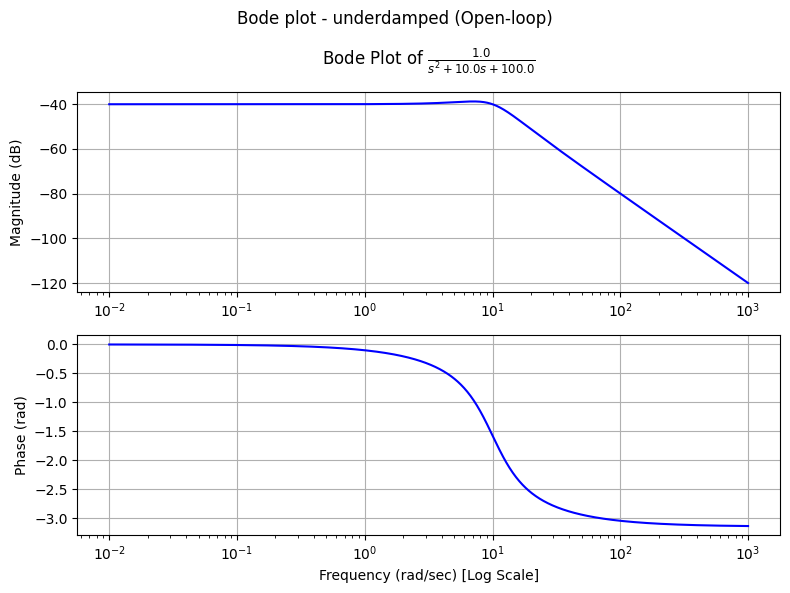

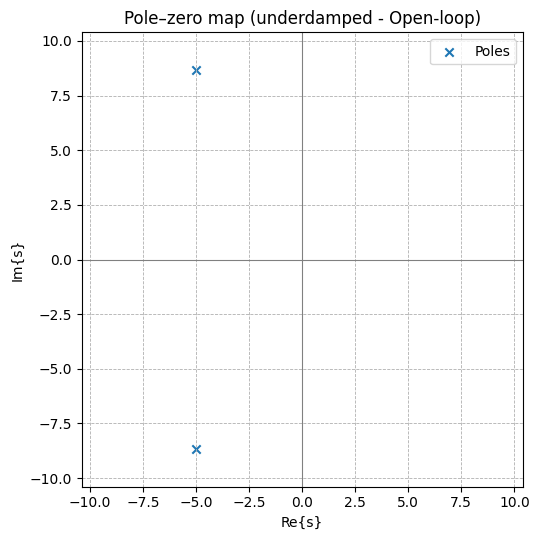

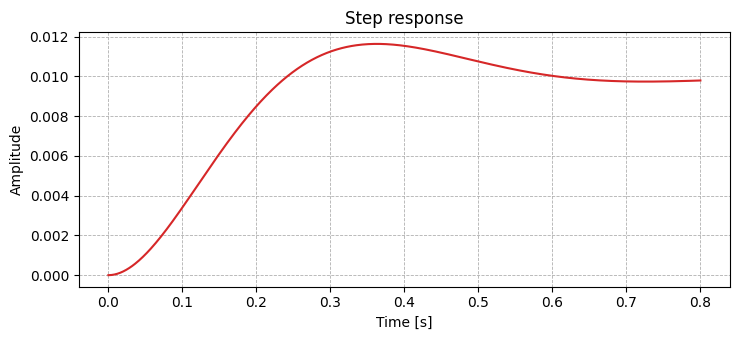


Closed-loop


1.0/(s**2 + 10.0*s + 101.0)

w_n=10.0499 rad/s, zeta=0.4975, w_d=8.7178 rad/s, K=0.0099 (underdamped)


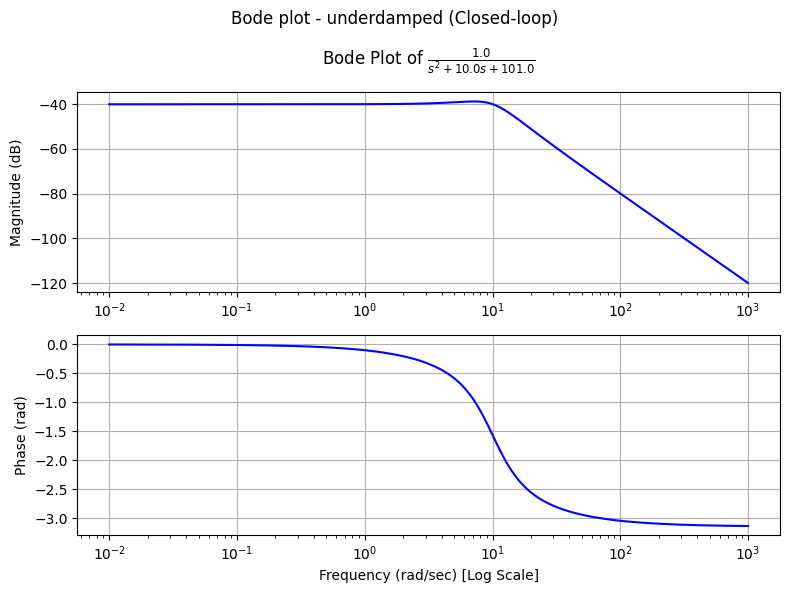

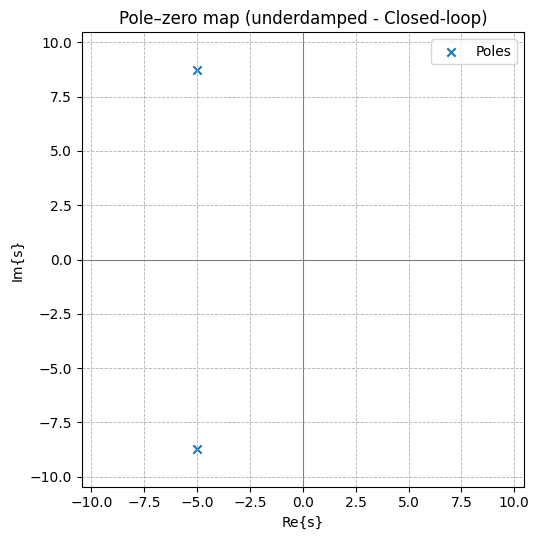

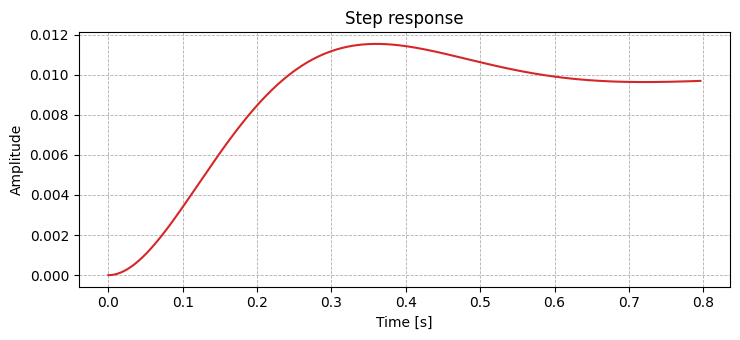

,w_n,zeta,w_d,T_p,T_r,T_s,loop
0,10.000000,0.500000,8.660254,0.362760,0.241840,0.8,Open-loop
1,10.049876,0.497519,8.717798,0.360365,0.239915,0.8,Closed-loop


In [ ]:
# Example run for item 2 analysis
example_mechanical = {"m": 1.0, "c": 10.0, "k": 100.0}
metrics_item2 = analyze_item2(example_mechanical, domain="mechanical", loops=("Open-loop", "Closed-loop"), response="Step", freq_decades=(-2, 3))
